### Classification Of APIs using API Summaries

#### Ravi Sivaraman

In [6]:
import pandas as pd
import yaml
import io



In [7]:
base_path = "/Users/ravis/Documents/GitHub/openapi-directory/APIs/"
api_df = pd.read_csv("~/Downloads/apis.csv")

In [8]:
## TODO: rewrite it as get_n_tags()

def get_three_tags(tagslist):
    index = 0
    threetags = []
    for tag in range(0,3):
        try:
            item  = tagslist[tag]
            threetags.append(item)
        except IndexError:
            threetags.append('')
    return threetags



### Parse all APIs

In [9]:
import re
apis = []
for index, row in api_df.iterrows():
    try:
        with open(base_path+row['API'], 'r') as stream:
            data_loaded = yaml.safe_load(stream)
            data_items =  list(data_loaded.keys())
            api_type = data_items[0]
            try:
                for key, val in data_loaded.items():
                    if key == "paths":
                        if api_type == "swagger":
                            for key2, val2 in val.items():
                                basePath = data_loaded["basePath"]
                                host = data_loaded["host"]
                                api_name = key2
                                api_http_type = list(val2.keys())[0]
                                api_summary = val2[api_http_type]['summary']
                                api_tags = val2[api_http_type]['tags']
                                api_row = [api_type,host,basePath,api_name,api_http_type,api_summary] + get_three_tags(api_tags)
                                api_summary_2 = ""
                                if api_summary:
                                    api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                                    if api_tags and type(api_tags) is list:
                                        api_summary_2 += " " + " ".join(api_tags)
                                        api_summary_2 =  api_summary_2.lower()

                                apis.append(api_row + ["".join(api_summary_2)] )
                        if api_type == "openapi":
                            api_name = list(val.keys())[0]
                            api_http_type = list(val[api_name].keys())[0]
                            api_summary = val[api_name][api_http_type]['summary']
                            api_tags = val[api_name][api_http_type]['tags']
                            api_row = [api_type,host,basePath,api_name,api_http_type,api_summary] + get_three_tags(api_tags)
                            api_summary_2 = ""
                            if api_summary:
                                api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                                if api_tags and type(api_tags) is list:
                                    api_summary_2 += " " + " ".join(api_tags)
                                    api_summary_2 = api_summary_2.lower()
                            apis.append(api_row + ["".join(api_summary_2)] )


            except Exception as e:
                continue
    except:
        continue
apis_df = pd.DataFrame.from_records(apis, columns=['api_type','host','basePath','api_name','api_http_type','api_summary','tag1', 'tag2', 'tag3', "api_summary_2"])


#Reference: https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0


In [10]:
def cosine_similarity(text1, text2):
    
    X_list = word_tokenize(text1) 
    Y_list = word_tokenize(text2)

    # sw contains the list of stopwords
    sw = stopwords.words('english') 
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine



In [11]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stopwords = StopWordRemoverFactory().get_stop_words()

def text_preprocess(series, stemmer, stopwords):
    df = series.str.replace("\n\t",  " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return df

apis_df['processed_text'] = text_preprocess(apis_df['api_summary_2'], stemmer, stopwords)

/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/ipykernel_58377/713083668.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace(r"[^a-zA-Z ]+", "")


In [12]:
import fasttext

0         get quotes for all symbols forex finance quotes
1       get a list of symbols for which we provide rea...
2       performs introspection of the provided bearer ...
3       retrieve a list of api requests that have been...
4       enumerate all active channels of the applicati...
                              ...                        
3681                                            all voice
3682                                   single audio voice
3683                                    single text voice
3684                                         delete voice
3685     list charge metrics by time range charge metrics
Name: processed_text, Length: 3686, dtype: object

In [14]:
import fasttext

model = fasttext.train_unsupervised('/Users/ravis/Downloads/wiki-news-300d-1M.vec')
apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

Read 301M words
Number of words:  18483
Number of labels: 0
Progress: 100.0% words/sec/thread:   43175 lr:  0.000000 avg.loss:  0.168916 ETA:   0h 0m 0s  9.1% words/sec/thread:   54861 lr:  0.045439 avg.loss:  1.319454 ETA:   0h46m19s 22.7% words/sec/thread:   55184 lr:  0.038633 avg.loss:  0.740638 ETA:   0h39m 9s 32.8% words/sec/thread:   55213 lr:  0.033620 avg.loss:  0.516682 ETA:   0h34m 3s 40.4% words/sec/thread:   30375 lr:  0.029793 avg.loss:  0.419499 ETA:   0h54m51s 44.1% words/sec/thread:   31583 lr:  0.027949 avg.loss:  0.383439 ETA:   0h49m29s  31977 lr:  0.027347 avg.loss:  0.372982 ETA:   0h47m49s 47.2% words/sec/thread:   32579 lr:  0.026412 avg.loss:  0.357725 ETA:   0h45m20s0.350543 ETA:   0h44m 6s 49.2% words/sec/thread:   33223 lr:  0.025395 avg.loss:  0.342618 ETA:   0h42m44s 51.2% words/sec/thread:   33830 lr:  0.024395 avg.loss:  0.328962 ETA:   0h40m19s 0.024002 avg.loss:  0.323916 ETA:   0h39m24s34448 lr:  0.023284 avg.loss:  0.315027 ETA:   0h37m48s 54.6% word

In [35]:
apis_df['vec']

0       [0.03719435, -0.015253557, -0.04589598, -0.021...
1       [-0.008268558, 0.0031177406, -0.022891957, -0....
2       [0.04091386, -0.046491396, 0.0038976828, -0.00...
3       [0.025302937, 0.015915517, -0.016523104, 0.008...
4       [-0.003093318, 0.0022154166, -0.012527056, 0.0...
                              ...                        
3681    [0.11873129, -0.07086635, -0.02338354, 0.06951...
3682    [0.08758139, -0.109601915, 0.092438266, 0.0939...
3683    [0.10316494, -0.010101309, 0.04449649, 0.09270...
3684    [0.05305753, -0.04358753, 0.06328352, 0.038250...
3685    [-0.04946267, 0.014706102, 0.014475949, 0.0375...
Name: vec, Length: 3686, dtype: object

In [33]:
model.save_model("apimodel.bin")

In [36]:

X =apis_df['vec']

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Plotting k against the sum of squared distance')
plt.show()

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
apis_df['cluster'] = kmeans.fit_predict(apis_df['vec'].values.tolist())

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
apis_df['x'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,0]
apis_df['y'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,1]
apis_df['z'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,2]

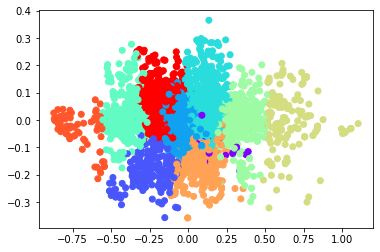

In [20]:
import matplotlib.pyplot as plt

plt.scatter(apis_df['x'], apis_df['y'], c=apis_df['cluster'], cmap='rainbow')

/var/folders/rr/gnmws3gs2xn3p2l0t4_lq7hc0000gn/T/ipykernel_58377/2588842332.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)


Text(0.5, 0.92, 'Tweet Clustering using K Means')

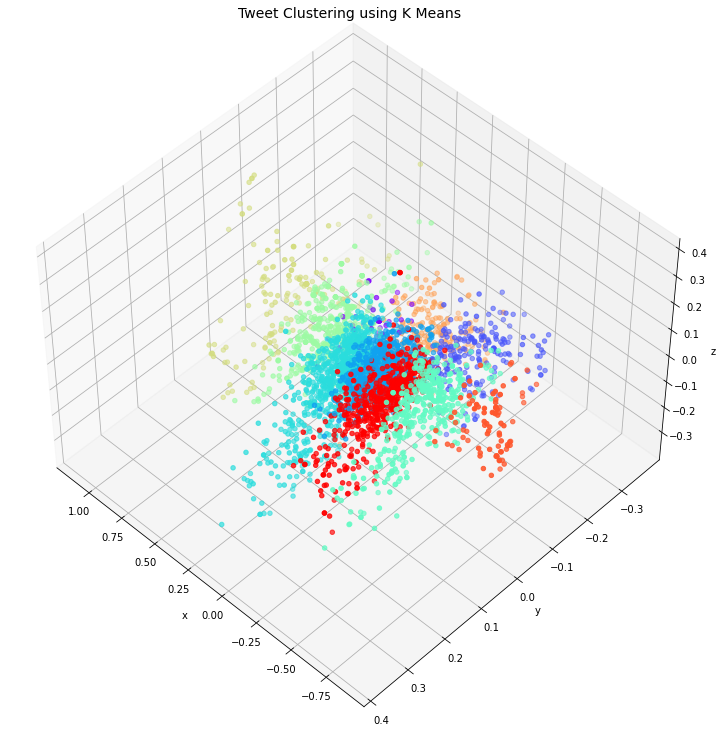

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(apis_df['x'],apis_df['y'],apis_df['z'], c=apis_df['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)

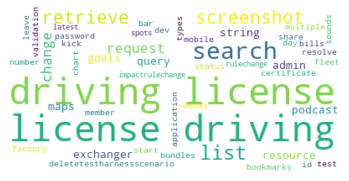

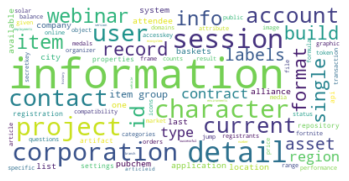

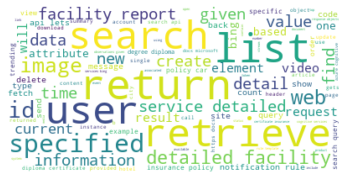

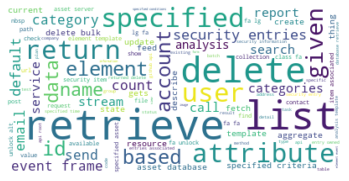

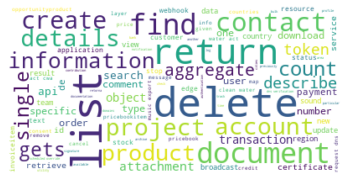

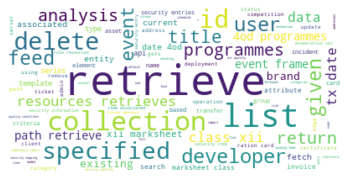

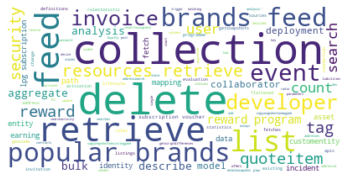

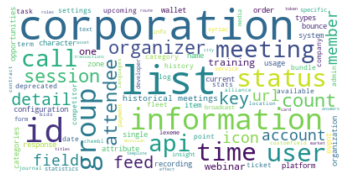

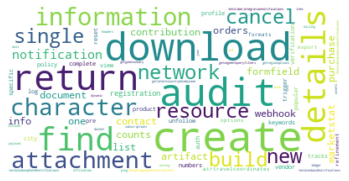

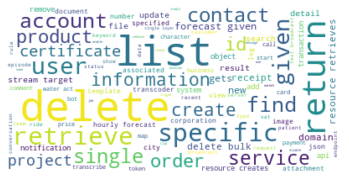

In [32]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
k_val = 10
vectorizer = TfidfVectorizer(stop_words={'english'})
apilists = apis_df["api_summary"].to_list()
X = vectorizer.fit_transform(apilists)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'apis':apilists}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
    s=kmeans_result[kmeans_result.cluster==k]
    text=s['apis'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [31]:
kmeans_result

,cluster,apis
0,2,Get quotes for all symbols
1,3,Get a list of symbols for which we provide rea...
2,4,Performs introspection of the provided Bearer ...
3,3,Retrieve a list of API Requests that have been...
4,2,Enumerate all active channels of the application
...,...,...
3681,4,all
3682,4,single-audio
3683,4,single-text
3684,4,delete


In [34]:
kmeans.labels_

array([2, 3, 4, ..., 4, 4, 2], dtype=int32)